Validation Accuracy: 0.9962
Test Accuracy: 0.9973

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8529
           1       1.00      1.00      1.00      9430

    accuracy                           1.00     17959
   macro avg       1.00      1.00      1.00     17959
weighted avg       1.00      1.00      1.00     17959



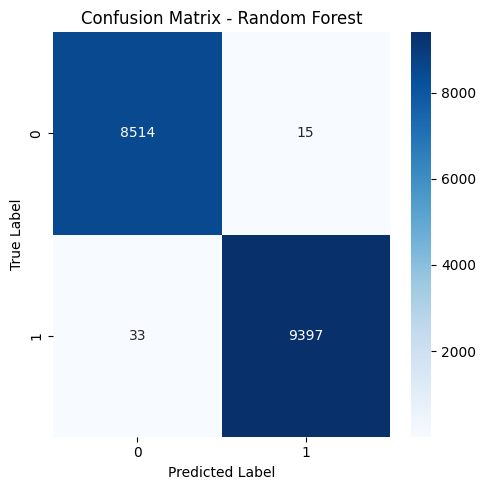

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load datasets
fake_news_path = r"C:\Users\tejas\OneDrive\Desktop\projectar\Fake.csv.zip"
true_news_path = r"C:\Users\tejas\OneDrive\Desktop\projectar\True.csv.zip"

df_fake = pd.read_csv(fake_news_path)
df_true = pd.read_csv(true_news_path)

# labels: 1 for fake, 0 for true
df_fake["label"] = 1
df_true["label"] = 0

# Merge and shuffle the datasets
news_df = pd.concat([df_fake, df_true], ignore_index=True)
news_df = news_df.sample(frac=1, random_state=123).reset_index(drop=True)  # shuffled

news_df.to_csv("news_dataset_rf.csv", index=False)

# Extract text and labels
X_text = news_df['text'].fillna("").astype(str)
y = news_df['label']

# Data splitting (40% train, 40% test, 20% validation)
X_train_test, X_val, y_train_test, y_val = train_test_split(X_text, y, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.5, random_state=1)


# Text vectorization (Bag of Words)
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 15],
    'min_samples_split': [2, 4]
}

# Perform grid search with cross-validation
clf = RandomForestClassifier(random_state=7)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_vec, y_train)

# Evaluate on validation set
val_preds = grid_search.predict(X_val_vec)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Retrain on full training + validation data
X_final_vec = vectorizer.fit_transform(pd.concat([X_train, X_val]))
y_final = pd.concat([y_train, y_val])

best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=7)
best_rf.fit(X_final_vec, y_final)

# Predict on test set
X_test_vec = vectorizer.transform(X_test)
test_preds = best_rf.predict(X_test_vec)

test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
